<a href="https://colab.research.google.com/github/royazizbarera/fast-api-dip/blob/main/inference_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mchong6/GANsNRoses.git
%cd GANsNRoses
!pip install tqdm gdown kornia scipy opencv-python dlib moviepy lpips aubio ninja

Cloning into 'GANsNRoses'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 180 (delta 1), reused 4 (delta 1), pack-reused 171 (from 1)
Receiving objects: 100% (180/180), 32.50 MiB | 17.27 MiB/s, done.
Resolving deltas: 100% (82/82), done.
/content/GANsNRoses
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.0/479.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.4 MB/s eta 0:00:00
  Created wheel for aubio: filename=aubio-0.4.9-cp310-cp310-linux_x86_64.whl size=425286 sha256=0f280d7638f044db4d1c364a2e1fccd1de382ce619c90464e0cc28dc1fff7cbe
  Stored in directory: /root/.cache/pip/w

In [2]:
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms, utils
from tqdm import tqdm
torch.backends.cudnn.benchmark = True
import copy
from util import *
from PIL import Image

from model import *
import moviepy.video.io.ImageSequenceClip
import scipy
import cv2
import dlib
import kornia.augmentation as K
from aubio import tempo, source

from IPython.display import HTML
from base64 import b64encode
from google.colab import files


/usr/local/lib/python3.10/dist-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [15]:
device = 'cuda'
latent_dim = 8
n_mlp = 5
num_down = 3

G_A2B = Generator(256, 4, latent_dim, n_mlp, channel_multiplier=1, lr_mlp=.01,n_res=1).to(device).eval()

ensure_checkpoint_exists('GNR_checkpoint.pt')
ckpt = torch.load('GNR_checkpoint.pt', map_location=device)

G_A2B.load_state_dict(ckpt['G_A2B_ema'])

# mean latent
truncation = 1
with torch.no_grad():
    mean_style = G_A2B.mapping(torch.randn([1000, latent_dim]).to(device)).mean(0, keepdim=True)


test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), inplace=True)
])

<ipython-input-15-d7a733fcab27>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('GNR_checkpoint.pt', map_location=device)


# Upload your own image

Saving taylor_swift.jpeg to taylor_swift.jpeg


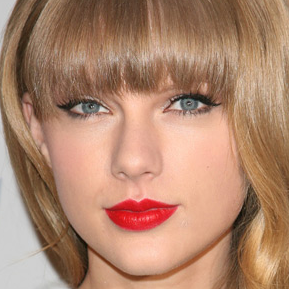

In [ ]:
# upload your own image
uploaded = files.upload()
filepath = list(uploaded.keys())[0]

image = cv2.imread(filepath)
height, width = image.shape[:2]

# Detect with dlib
face_detector = dlib.get_frontal_face_detector()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# grab first face
face = face_detector(gray, 1)[0]

# Face crop with dlib and bounding box scale enlargement
x, y, size = get_boundingbox(face, width, height)
cropped_face = image[y:y+size, x:x+size]
cropped_face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
cropped_face = Image.fromarray(cropped_face)
cropped_face

# Upload your own image
Automatically detects and crops the face

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


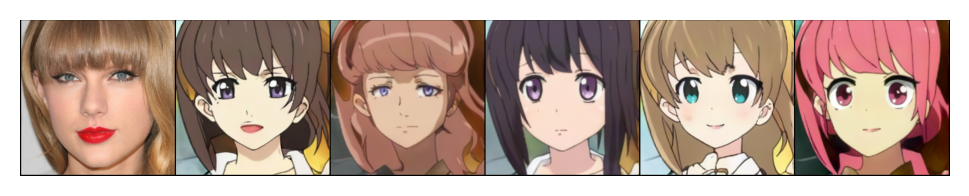

In [ ]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 200

torch.manual_seed(84986)

num_styles = 5
style = torch.randn([num_styles, latent_dim]).to(device)


# real_A = Image.open('./samples/margot_robbie.jpg')
real_A = cropped_face
real_A = test_transform(real_A).unsqueeze(0).to(device)

with torch.no_grad():
    A2B_content, _ = G_A2B.encode(real_A)
    fake_A2B = G_A2B.decode(A2B_content.repeat(num_styles,1,1,1), style)
    A2B = torch.cat([real_A, fake_A2B], 0)

display_image(utils.make_grid(A2B.cpu(), normalize=True, range=(-1, 1), nrow=10))

# Style Interpolation

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


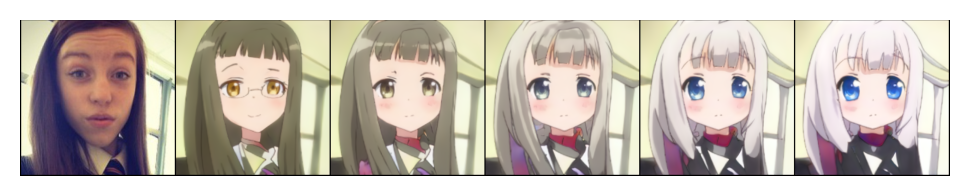

In [ ]:
torch.manual_seed(13421)

real_A = Image.open('./samples/female_12427.jpg')
real_A = test_transform(real_A).unsqueeze(0).to(device)

style1 = G_A2B.mapping(torch.randn([1, latent_dim]).to(device))
style2 = G_A2B.mapping(torch.randn([1, latent_dim]).to(device))

with torch.no_grad():
    A2B = []
    A2B_content, _ = G_A2B.encode(real_A)
    for i in np.linspace(0,1,5):
        new_style = i*style1 + (1-i)*style2
        fake_A2B = G_A2B.decode(A2B_content, new_style, use_mapping=False)
        A2B.append(torch.cat([fake_A2B], 0))
    A2B = torch.cat([real_A] + A2B, 0)

display_image(utils.make_grid(A2B.cpu(), normalize=True, range=(-1, 1), nrow=10))

#Style Interpolation
Use SeFA (https://arxiv.org/pdf/2007.06600.pdf) to find latent directions that can be used for style edting

In [ ]:
modulate = {
    k: v
    for k, v in ckpt["G_A2B_ema"].items()
    if "modulation" in k and "to_rgbs" not in k and "weight" in k
}

weight_mat = []
for k, v in modulate.items():
    weight_mat.append(v)

W = torch.cat(weight_mat, 0)
eigvec = torch.svd(W).V.to("cpu")

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


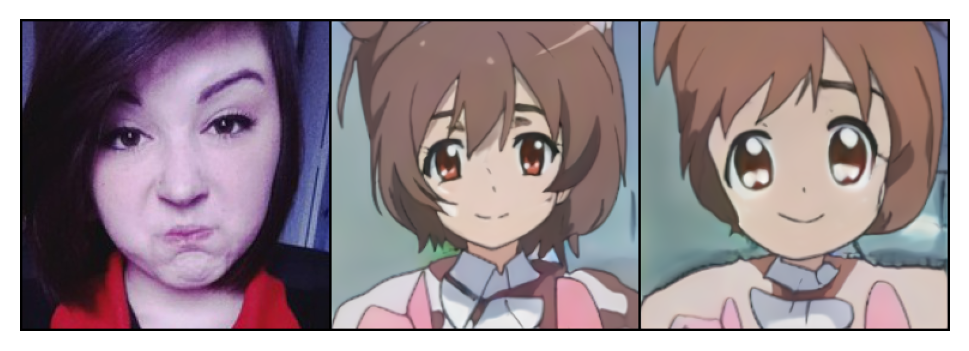

In [ ]:
plt.rcParams['figure.dpi'] = 200

real_A = Image.open('./samples/female_11025.jpg')
real_A = test_transform(real_A).unsqueeze(0).to(device)


eig_idx = 2 # which eigenvec to choose
eig_scale = 4 # how much to scale the eigvec

style = G_A2B.mapping(torch.randn([1, latent_dim]).to(device))
direction = eig_scale * eigvec[:, eig_idx].unsqueeze(0).to(device)


with torch.no_grad():
    A2B_content, _ = G_A2B.encode(real_A)
    fake_A2B = G_A2B.decode(A2B_content, style, use_mapping=False)
    fake_A2B2 = G_A2B.decode(A2B_content, style+direction, use_mapping=False)

display_image(utils.make_grid(torch.cat([real_A, fake_A2B, fake_A2B2], 0).cpu(), normalize=True, range=(-1, 1)))

#Video Translation
Given an input face video, produce a grid of translated videos of different styles.

Uses dlib face detection to form a bounding box around the face. Bounding box is based on the first face detected on the first frame. Thus the face in the video should not move too much or it might move out of the bounding box.

There are 4 options for video generation
1) normal: Each grid have a different static style.

2) blend: Each grid have a style that interpolates with time.

3) beat: Each grid have their style change according to the beat of the music.

4) eig: Each grid have their style change using eigenvectors to the beat of the music.

In [22]:
# input video
# Upload the video file
# uploaded = files.upload()

# Extract the filename
# inpath = list(uploaded.keys())[0]
inpath = './roy_3deti.mp4'
outpath = './samples/output_custom_eig.mp4'

mode = 'eig'
assert mode in ('normal', 'blend', 'beat', 'eig')


# Frame numbers and length of output video
start_frame=0
end_frame=None
frame_num = 0
mp4_fps= 30
faces = None
smoothing_sec=.7
eig_dir_idx = 1 # first eig isnt good so we skip it

frames = []
reader = cv2.VideoCapture(inpath)
num_frames = int(reader.get(cv2.CAP_PROP_FRAME_COUNT))

# get beats from audio
win_s = 512                 # fft size
hop_s = win_s // 2          # hop size

s = source(inpath, 0, hop_s)
samplerate = s.samplerate
o = tempo("default", win_s, hop_s, samplerate)
delay = 4. * hop_s
# list of beats, in samples
beats = []

# total number of frames read
total_frames = 0
while True:
    samples, read = s()
    is_beat = o(samples)
    if is_beat:
        this_beat = int(total_frames - delay + is_beat[0] * hop_s)
        beats.append(this_beat/ float(samplerate))
    total_frames += read
    if read < hop_s: break
#print len(beats)
beats = [math.ceil(i*mp4_fps) for i in beats]


if mode == 'blend':
    shape = [num_frames, 8, latent_dim] # [frame, image, channel, component]
    all_latents = np.random.randn(*shape).astype(np.float32)
    all_latents = scipy.ndimage.gaussian_filter(all_latents, [smoothing_sec * mp4_fps, 0, 0], mode='wrap')
    all_latents /= np.sqrt(np.mean(np.square(all_latents)))
    all_latents = torch.from_numpy(all_latents).to(device)
else:
    all_latents = torch.randn([8, latent_dim]).to(device)

if mode == 'eig':
    all_latents = G_A2B.mapping(all_latents)

in_latent = all_latents

# Face detector
face_detector = dlib.get_frontal_face_detector()

assert start_frame < num_frames - 1
end_frame = end_frame if end_frame else num_frames

while reader.isOpened():
    _, image = reader.read()
    if image is None:
        break

    if frame_num < start_frame:
        continue
    # Image size
    height, width = image.shape[:2]

    # 2. Detect with dlib
    if faces is None:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_detector(gray, 1)
    if len(faces):
        # For now only take biggest face
        face = faces[0]

    # --- Prediction ---------------------------------------------------
    # Face crop with dlib and bounding box scale enlargement
    x, y, size = get_boundingbox(face, width, height)
    cropped_face = image[y:y+size, x:x+size]
    cropped_face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
    cropped_face = Image.fromarray(cropped_face)
    frame = test_transform(cropped_face).unsqueeze(0).to(device)

    with torch.no_grad():
        A2B_content, A2B_style = G_A2B.encode(frame)
        if mode == 'blend':
            in_latent = all_latents[frame_num]
        elif mode == 'normal':
            in_latent = all_latents
        elif mode == 'beat':
            if frame_num in beats:
                in_latent = torch.randn([8, latent_dim]).to(device)

        if mode == 'eig':
            if frame_num in beats:
                direction = 3 * eigvec[:, eig_dir_idx].unsqueeze(0).expand_as(all_latents).to(device)
                in_latent = all_latents + direction
                eig_dir_idx += 1

            fake_A2B = G_A2B.decode(A2B_content.repeat(8,1,1,1), in_latent, use_mapping=False)
        else:
            fake_A2B = G_A2B.decode(A2B_content.repeat(8,1,1,1), in_latent)



        fake_A2B = torch.cat([fake_A2B[:4], frame, fake_A2B[4:]], 0)

        fake_A2B = utils.make_grid(fake_A2B.cpu(), normalize=True, value_range=(-1, 1), nrow=3)


    #concatenate original image top
    fake_A2B = fake_A2B.permute(1,2,0).cpu().numpy()
    frames.append(fake_A2B*255)

    frame_num += 1

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(frames, fps=mp4_fps)

# save to temporary file. hack to make sure ffmpeg works
clip.write_videofile('./temp.mp4')

# use ffmpeg to add audio to video
!ffmpeg -i ./temp.mp4 -i $inpath -c copy -map 0:v:0 -map 1:a:0 $outpath -y
!rm ./temp.mp4

Moviepy - Building video ./temp.mp4.
Moviepy - Writing video ./temp.mp4



Moviepy - Done !
Moviepy - video ready ./temp.mp4
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-li

In [23]:
mp4 = open(outpath,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)
